In [1]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
from sklearn.decomposition import PCA, IncrementalPCA
from scipy import stats
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
cmap = 'husl'

In [3]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [4]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
#results_dir = os.path.join('../../data/', 'results')

In [5]:
analysis_name = 'corrs_ordered_up_for_PCA'

In [6]:
data_dir = os.path.join(results_dir, analysis_name, 'corrs_results')

In [7]:
data_dir

'/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/corrs_results'

In [8]:
corrsdir = os.path.join(results_dir, analysis_name)

In [9]:
param_corrs = glob.glob(os.path.join(corrsdir, 'isfc_*'))

In [10]:
param_corrs

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/isfc_eigenvector_centrality_laplace_50',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/corrs_ordered_up_for_PCA/isfc_PCA_laplace_50']

In [11]:
levels = np.arange(0,4,1)
conditions = ['intact', 'paragraph', 'rest', 'word']
Reduction_type = ['PCA', 'eigenvector_centrality']

In [12]:
# levels = np.arange(0,4,1)
# conditions = ['intact', 'paragraph', 'rest', 'word']

# colors = sns.color_palette("cubehelix", 4)

# for l in levels:

#     for e, cond in enumerate(conditions):
#         #con = os.path.join(corrsdir, f'lev_{l}'+ f'_{cond}'+ '.npy')
#         con = os.path.join(param_corrs[0], f'd_{l}' + f'_r_{cond}' + '.npy')

#         corrs = np.load(con)
#         split = np.cumsum([len(xi) for xi in corrs])[:-1]
#         stacked = np.vstack(corrs)
#         pca = IncrementalPCA(n_components=np.shape(stacked)[1])
#         x_r = np.vsplit(pca.fit_transform(np.vstack(stacked)), split)
        
#         plt.plot(np.cumsum(pca.explained_variance_ratio_), color = colors[e])
#         plt.xlabel('number of components')
#         plt.ylabel('cumulative explained variance')
        
#     plt.show()
#     plt.clf()

In [13]:
cmap = 'husl'

In [106]:
levels = np.arange(0,4,1)
conditions = ['intact', 'paragraph', 'rest', 'word']

#colors = sns.color_palette("cubehelix", 4)

thres_data = pd.DataFrame()

for r in np.arange(2):
    print(r)
    for l in levels:

        full_pca_data = pd.DataFrame()

        for e, cond in enumerate(conditions):
            #con = os.path.join(corrsdir, f'lev_{l}'+ f'_{cond}'+ '.npy')
            con = os.path.join(param_corrs[r], f'd_{l}' + f'_r_{cond}' + '.npy')
            corrs = np.load(con)

            for p in np.arange(corrs.shape[0]):
                
                x = corrs[p]
                pca = PCA(n_components=corrs.shape[1])
                pca.fit_transform(x)

                pc_data = pd.DataFrame()
                pc_data['variance'] = np.cumsum(pca.explained_variance_ratio_)
                pc_data['condition'] = np.matlib.repmat(cond, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
                pc_data['subject'] = np.matlib.repmat(p, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
                pc_data['components'] = pc_data.index 
                pc_data['total components'] = pc_data.components.max() + 1
                pc_data['percent components'] = pc_data['components']/pc_data['total components']
                
                absolute_val_array = np.abs(pc_data.variance.values - .85)
                smallest_difference_index = absolute_val_array.argmin()
                closest_element = pc_data.variance.values[smallest_difference_index]
                mask = pc_data.variance.values == closest_element
                pc_data_thres = pc_data[mask]
                pc_data_thres['level'] = l
                pc_data_thres['reduction'] = Reduction_type[r]
                pc_data_thres['total components'] = pc_data.components.max() + 1
                if thres_data.empty:
                    thres_data = pc_data_thres
                else:
                    thres_data = thres_data.append(pc_data_thres)

                    
                if full_pca_data.empty:
                    full_pca_data = pc_data
                else:
                    full_pca_data = full_pca_data.append(pc_data)
        print(str(l))


        fig, ax = plt.subplots()
#         sns.lineplot(x="components", y="variance",
#                      hue="condition",
#                      data=full_pca_data, ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.lineplot(x='percent components', y="variance",
                     hue="condition",
                     data=full_pca_data, ax=ax, palette=cmap, hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.despine(ax=ax, left=True)
        if r == 1:
            ax.lines[0].set_linestyle("--")
            ax.lines[1].set_linestyle("--")
            ax.lines[2].set_linestyle("--")
            ax.lines[3].set_linestyle("--")
        #ax.set_title('Cumulative varince explained')
        ax.set_ylabel('Cumulative \n varince explained',fontsize=24)
        #ax.set_xlabel('Number of components',fontsize=24)
        ax.set_xlabel('Proportion of components',fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)

    #     ax.hlines(y=50, xmin=0, xmax=100, linewidth=2, color='r')
    #     #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
    #     leg = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    #     for line in leg.get_lines():
    #         line.set_linewidth(4.0)

        outfile = os.path.join(figdir, 'pca_700_nodes_level_' + str(l+1) + '_' + Reduction_type[r] + '.pdf')
        plt.tight_layout()
        #plt.show()
        plt.savefig(outfile)
        plt.clf()

0


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

0
1
2
3
1
0
1
2
3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [107]:
thres_data['percent components'] = thres_data['components']/thres_data['total components']

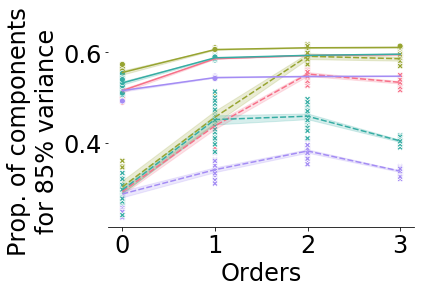

In [135]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = 'level', y = 'percent components', hue='condition', style = 'reduction', palette=cmap, 
                hue_order=['intact', 'paragraph', 'word', 'rest'], data = thres_data)
sns.lineplot(x = 'level', y = 'percent components', hue='condition', ax=ax, style = 'reduction', palette=cmap, 
             hue_order=['intact', 'paragraph', 'word', 'rest'], data = thres_data)
sns.despine(ax=ax, left=True)
#ax.set_title('Cumulative varince explained')
ax.set_ylabel('Prop. of components\nfor 85% variance',fontsize=24)
ax.set_xlabel('Orders',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.legend().set_visible(False)
plt.tight_layout()
#ax.set_ylim(0, .7)
# legend_elements = [Line2D([0], [0], color='black', linestyle = 'solid', lw=2, label='PCA'),
#                    Line2D([0], [0], linestyle = 'dashed', color='black', lw=2, label='Eigenvector centrality')]
# ax.legend(handles=legend_elements, loc='lower right', fontsize=18, bbox_to_anchor=(1.95, 0.75))
outfile = os.path.join(figdir, 'pca_700_nodes_across_levels.pdf')
plt.savefig(outfile)


In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = 'level', y = 'components', hue='condition', style = 'reduction', palette=cmap, 
                hue_order=['intact', 'paragraph', 'word', 'rest'], data = thres_data)
sns.lineplot(x = 'level', y = 'components', hue='condition', ax=ax, style = 'reduction', palette=cmap, 
             hue_order=['intact', 'paragraph', 'word', 'rest'], data = thres_data)
sns.despine(ax=ax, left=True)
#ax.set_title('Cumulative varince explained')
ax.set_ylabel('Number of components',fontsize=24)
ax.set_xlabel('Levels',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.legend().set_visible(False)

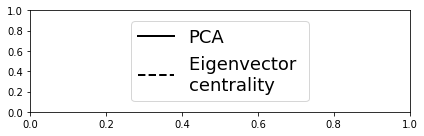

In [129]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6,2))
legend_elements = [Line2D([0], [0], color='black', linestyle = 'solid', lw=2, label='PCA'),
                   Line2D([0], [0], linestyle = 'dashed', color='black', lw=2, label='Eigenvector \ncentrality')]
ax.legend(handles=legend_elements, loc='center', fontsize=18)
outfile = os.path.join(figdir, 'pca_700_nodes_legend.pdf')
plt.tight_layout()
plt.savefig(outfile)
